# Affinity Calculations using RDataFrame for CLAS12 Dihadron events

### Rowan Kelleher
#### October 20th, 2022

This notebook takes in TTrees and plots affinity values. TTrees come from LundAnalysis.C (in repo: https://github.com/RowanKell/MCLundAnalysis/blob/dev2/LundAnalysis.C)

Process:
1. Wildcard (\*) is used to take in many ROOT files into one RDataFrame for each bin variable for each pion
1. The means at each bin are then calculated using the Filter() and Mean() methods
1. These means are then fed through the Affinity TensorFlow model and affinity values are saved to numpy arrays
1. From these arrays we then plot affinity vs x, z, pT depending on the binning variable

In progress:
1. The dihadron affinity can be calculated from the product of the two pions, but this hasn't been done yet as the single pion affinity is still being worked on

In [1]:
from ROOT import TFile,TTree,TCanvas,TH1F,gStyle,TLatex,gPad,TLegend,TLorentzVector,TH2F,TLine,TF1,TBox,RDataFrame,TPad,TF2
import ROOT
import numpy as np
import awkward as awk
import uproot
import pandas as pd
import matplotlib.pyplot as plot
from pandas import read_excel 
from copy import deepcopy
from ipywidgets import *
import logging, os 
import time
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
print("tf.__version__", tf.__version__)


Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-odz43nvp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


tf.__version__ 2.7.0


In [8]:
#d_plus = RDataFrame("tree_MC_plus", "../OutputFiles/Slurm/Oct_26/file_*.root").Filter("R0max < 0.3").Filter("R1max < 0.3").Filter("R2max < 0.3")
# d_plus = RDataFrame("tree_MC_plus", "../OutputFiles/Test_10_27/file2.root")
# d_minus = RDataFrame("tree_MC_minus", "../OutputFiles/Slurm/Oct_26/file_*.root")
# d_plus = RDataFrame("tree_MC_plus", "../OutputFiles/Slurm/Oct_27/file_*.root").Filter("R0max < 0.3").Filter("R1max < 0.3").Filter("R2max < 0.3")
# d_minus = RDataFrame("tree_MC_minus", "../OutputFiles/Slurm/Oct_27/file_*.root").Filter("R0max < 0.3").Filter("R1max < 0.3").Filter("R2max < 0.3")

d_plus = RDataFrame("tree_MC_plus", "../OutputFiles/Slurm/Oct_27/file_*.root").Filter("q_TdivQ < 0.3")
d_minus = RDataFrame("tree_MC_minus", "../OutputFiles/Slurm/Oct_27/file_*.root").Filter("q_TdivQ < 0.3")

In [9]:
#Bins (each has 8 including 0)
Mhbins = np.linspace(0,1.3,8)
pTbins = np.linspace(0.1,0.8,8)
xbins = np.array([0,0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0,0.35,0.43,0.49,0.55,0.62,0.7,0.83])
Q2bins = np.array([0,1.2,1.8,2.3,3.1,4.3,7,11.1])

Need variables: x, z_h, Q2, p_T, R0, R1, R2 - total of 7

In [10]:
#Filtering data
#We have a list of 7 arrays bc we need an array of x values, z values, p_t values, etc for every bin
#First index will be the variable, second index is the i-th binning of that variable
#e.g. - px[1][3] will access the z_h mean for the 3rd (4th) bin of the x binning of piplus
px = [np.zeros(7).tolist() for i in range(7)]
pz = [np.zeros(7).tolist() for i in range(7)]
pMh=[np.zeros(7).tolist() for i in range(7)]
ppT=[np.zeros(7).tolist() for i in range(7)]
pxQ2 = [np.zeros(7).tolist() for i in range(7)]

mx=[np.zeros(7).tolist() for i in range(7)]
mz=[np.zeros(7).tolist() for i in range(7)]
mpT=[np.zeros(7).tolist() for i in range(7)]
mMh=[np.zeros(7).tolist() for i in range(7)]

In [11]:
#px=[list(np.zeros(7)) for i in range(7)]

In [12]:
varName = np.array(["x", "z", "Q2", "pT", "R0max", "R1max", "R2max"])

In [13]:
start_time = time.time()
xformat = "x <= {} && x > {}"
zformat = "z <= {} && z > {}"
Mhformat = "Mh <= {} && Mh > {}"
pTformat = "pT <= {} && pT > {}"

#Piplus
#x bins
start_time = time.time()
#i is the kinematic variable
#j is the bin num
for i in range(7):
    for j in range(7):
        #j + 1 as we only use 0 as a left bound, not a top bound - hence start with top bound at first index, not 0th
        px[j][i] = d_plus.Filter(xformat.format(xbins[j + 1],xbins[j])).Mean(varName[i])
        mx[j][i] = d_minus.Filter(xformat.format(xbins[j + 1],xbins[j])).Mean(varName[i])
#zbins
for i in range(7):
    for j in range(7):
        pz[j][i] = d_plus.Filter(zformat.format(zbins[j + 1],zbins[j])).Mean(varName[i])
#Mhbins
for i in range(7):
    for j in range(7):
        ppT[j][i] = d_plus.Filter(pTformat.format(pTbins[j + 1],pTbins[j])).Mean(varName[i])

        
#Piminus
# #
# for i in range(7):
#     for j in range(7):
for i in range(7):
    for j in range(7):
        mz[j][i] = d_minus.Filter(zformat.format(zbins[j + 1],zbins[j])).Mean(varName[i])
for i in range(7):
    for j in range(7):
        mpT[j][i] = d_minus.Filter(pTformat.format(pTbins[j + 1],pTbins[j])).Mean(varName[i])
        
finish = time.time()
print(finish - start_time)

0.20636677742004395


In [14]:
# c = TCanvas("c","c",500,500)
# h7 = pxdata.Histo1D(("h7",";R1 ;Counts", 1000, -1, 5), "R1max")
# h7.Draw("histo")
# c.Draw()
# # varName[5]

Now need to actually run the process by calling .GetValue() on one variable per RDataFrame (we have 2, one for each pion

In [15]:
#print(px)
forstart = time.time()
for i in range(7):
    for j in range(7):
        px[i][j]=px[i][j].GetValue()
        pz[i][j] = pz[i][j].GetValue()
        ppT[i][j] = ppT[i][j].GetValue()
        mx[i][j] = mx[i][j].GetValue()
        mz[i][j] = mz[i][j].GetValue()
        mpT[i][j] = mpT[i][j].GetValue()
forend = time.time()
print("took: " + str(forend - forstart))

took: 23.778876066207886


In [16]:
collinear_region_name = 'collinear'
current_region_name = 'current'
target_region_name = 'target'
TMD_region_name = 'TMD'
soft_region_name = 'soft'
collinear_lable_name = 'collinearaff'
target_lable_name = 'targetaff'
current_lable_name = 'currentaff'
TMD_lable_name = 'tmdaff'
soft_lable_name = 'softaff'

tmd_model_name = '../../SIDIS-Affinity/models/final_%s' % TMD_region_name
tmd_model = tf.keras.models.load_model(tmd_model_name)
target_model_name = '../../SIDIS-Affinity/models/final_%s' % target_region_name
target_model = tf.keras.models.load_model(target_model_name)
collinear_model_name = '../../SIDIS-Affinity/models/final_%s' % collinear_region_name
collinear_model = tf.keras.models.load_model(collinear_model_name)
current_model_name = '../../SIDIS-Affinity/models/final_%s' % current_region_name
current_model = tf.keras.models.load_model(current_model_name)
soft_model_name = '../../SIDIS-Affinity/models/final_%s' % soft_region_name
soft_model = tf.keras.models.load_model(soft_model_name)

varName = np.array(["x", "z", "Q2", "pT", "R0max", "R1max", "R2max"])

In [17]:
#var order: 
#0: x
#1: z_h
#2: Q2
#3: p_T
#4: R0
#5: R1
#6: R2

def calculator(array, region, binType, binnedVariable = 0):
    if binType == "x":
        z = array[1]
        Q2 = array[2]
        pT = array[3]
        R0max = array[4]
        R1max = array[5]
        R2max = array[6]
#         R0max = 0.3
#         R1max = 0.3
#         R2max = 0.3
        x = binnedVariable
    elif binType == "z":
        x = array[0]
        Q2 = array[2]
        pT = array[3]
        R0max = array[4]
        R1max = array[5]
        R2max = array[6]
        z = binnedVariable
    elif binType == "pT":
        x = array[0]
        z = array[1]
        Q2 = array[2]
        pT = binnedVariable
        R0max = array[4]
        R1max = array[5]
        R2max = array[6]
        
    test_features = pd.DataFrame({'pT':pT,'Q2':Q2,'x':x,'z':z,'R0max':R0max,'R1max':R1max,'R2max':R2max},index=[0])

    if region == 'tmd':
        prediction = tmd_model.predict(test_features).flatten()
        
    elif region == 'target':
        prediction = target_model.predict(test_features).flatten()
        
    elif region == 'collinear':
        prediction = collinear_model.predict(test_features).flatten()

    elif region == 'soft':
        prediction = soft_model.predict(test_features).flatten()

    else:
        prediction = current_model.predict(test_features).flatten()

    return prediction[0] #returns affinity value

In [18]:
colxaffinityplus = np.zeros(7)
colzaffinityplus = np.zeros(7)
colpTaffinityplus = np.zeros(7)
TMDxaffinityplus = np.zeros(7)
TMDzaffinityplus = np.zeros(7)
TMDpTaffinityplus = np.zeros(7)
Currentxaffinityplus = np.zeros(7)
Currentzaffinityplus = np.zeros(7)
CurrentpTaffinityplus = np.zeros(7)

colxaffinityminus = np.zeros(7)
colzaffinityminus = np.zeros(7)
colpTaffinityminus = np.zeros(7)
TMDxaffinityminus = np.zeros(7)
TMDzaffinityminus = np.zeros(7)
TMDpTaffinityminus = np.zeros(7)
Currentxaffinityminus = np.zeros(7)
Currentzaffinityminus = np.zeros(7)
CurrentpTaffinityminus = np.zeros(7)

region = "collinear"
region2 = "tmd"
region3 = "current"
for i in range(7):
    colzaffinityplus[i] = calculator(pz[i], region, "z", zbins[i+1])
    colxaffinityplus[i] = calculator(px[i], region, "x", xbins[i+1])
    colpTaffinityplus[i] = calculator(ppT[i], region, "pT", pTbins[i+1])
    TMDzaffinityplus[i] = calculator(pz[i], region2, "z", zbins[i+1])
    TMDxaffinityplus[i] = calculator(px[i], region2, "x", xbins[i+1])
    TMDpTaffinityplus[i] = calculator(ppT[i], region2, "pT", pTbins[i+1])
    Currentzaffinityplus[i] = calculator(pz[i], region3, "z", zbins[i+1])
    Currentxaffinityplus[i] = calculator(px[i], region3, "x", xbins[i+1])
    CurrentpTaffinityplus[i] = calculator(ppT[i], region3, "pT", pTbins[i+1])
    
    colzaffinityminus[i] = calculator(mz[i], region, "z", zbins[i+1])
    colxaffinityminus[i] = calculator(mx[i], region, "x", xbins[i+1])
    colpTaffinityminus[i] = calculator(mpT[i], region, "pT", pTbins[i+1])
    TMDzaffinityminus[i] = calculator(mz[i], region2, "z", zbins[i+1])
    TMDxaffinityminus[i] = calculator(mx[i], region2, "x", xbins[i+1])
    TMDpTaffinityminus[i] = calculator(mpT[i], region2, "pT", pTbins[i+1])
    Currentzaffinityminus[i] = calculator(mz[i], region3, "z", zbins[i+1])
    Currentxaffinityminus[i] = calculator(mx[i], region3, "x", xbins[i+1])
    CurrentpTaffinityminus[i] = calculator(mpT[i], region3, "pT", pTbins[i+1])

In [19]:
Mhbinsno0 = np.linspace(0.3,1.3,7)
pTbinsno0 = np.linspace(0.2,0.8,7)
xbinsno0 = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbinsno0 = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])

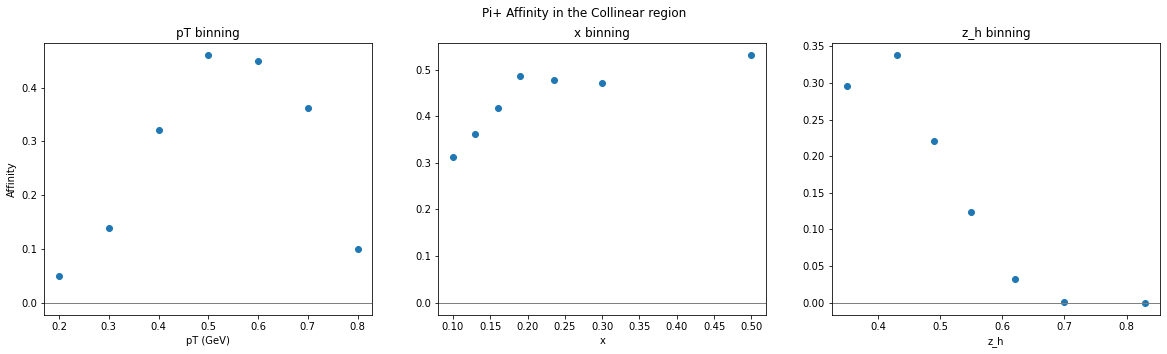

In [20]:
fig, (ax1, ax2, ax3) = plot.subplots(1, 3, figsize = (20, 5))
fig.suptitle("Pi+ Affinity in the Collinear region")
ax1.set(ylabel = "Affinity")
ax1.scatter(pTbinsno0, colpTaffinityplus)
ax1.axhline(y=0, color="gray", lw = 1)
ax1.set_title("pT binning")
ax1.set(xlabel = "pT (GeV)")
ax2.scatter(xbinsno0, colxaffinityplus)
ax2.axhline(y=0, color="gray", lw = 1)
ax2.set_title("x binning")
ax2.set(xlabel = "x")
ax3.scatter(zbinsno0, colzaffinityplus)
ax3.axhline(y=0, color="gray", lw = 1)
ax3.set_title("z_h binning")
ax3.set(xlabel = "z_h")
plot.savefig("collinear.png")

[Text(0.5, 0, 'z_h')]

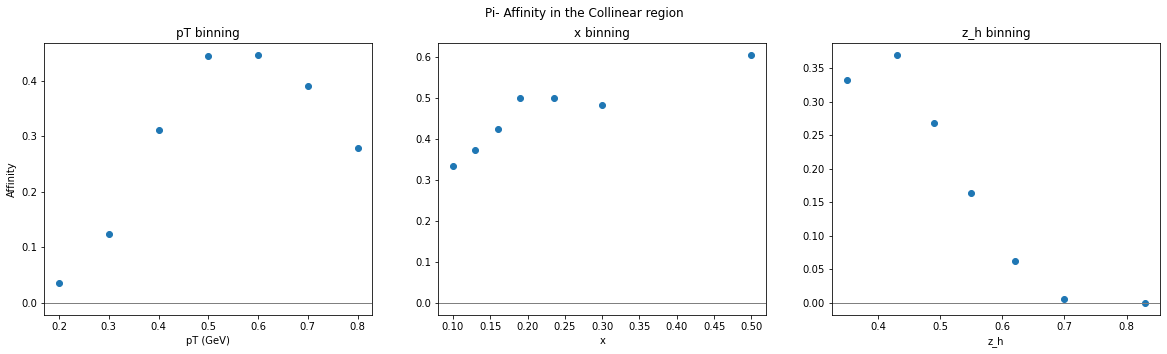

In [21]:
fig, (ax1, ax2, ax3) = plot.subplots(1, 3, figsize = (20, 5))
fig.suptitle("Pi- Affinity in the Collinear region")
ax1.set(ylabel = "Affinity")
ax1.scatter(pTbinsno0, colpTaffinityminus)
ax1.axhline(y=0, color="gray", lw = 1)
ax1.set_title("pT binning")
ax1.set(xlabel = "pT (GeV)")
ax2.scatter(xbinsno0, colxaffinityminus)
ax2.axhline(y=0, color="gray", lw = 1)
ax2.set_title("x binning")
ax2.set(xlabel = "x")
ax3.scatter(zbinsno0, colzaffinityminus)
ax3.axhline(y=0, color="gray", lw = 1)
ax3.set_title("z_h binning")
ax3.set(xlabel = "z_h")


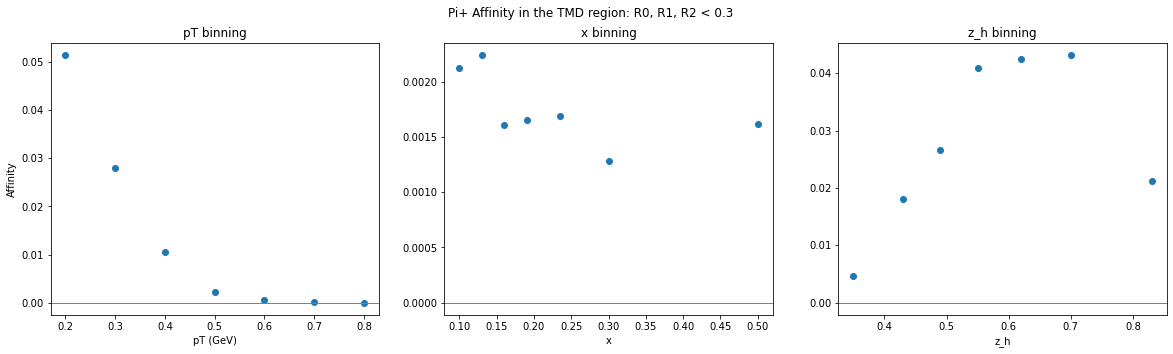

In [22]:
fig2, (ax12, ax22, ax32) = plot.subplots(1, 3, figsize = (20, 5))
fig2.suptitle("Pi+ Affinity in the TMD region: R0, R1, R2 < 0.3")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, TMDpTaffinityplus)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, TMDxaffinityplus)
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, TMDzaffinityplus)
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")
plot.savefig("wcutsandsetvals.png")


[Text(0.5, 0, 'z_h')]

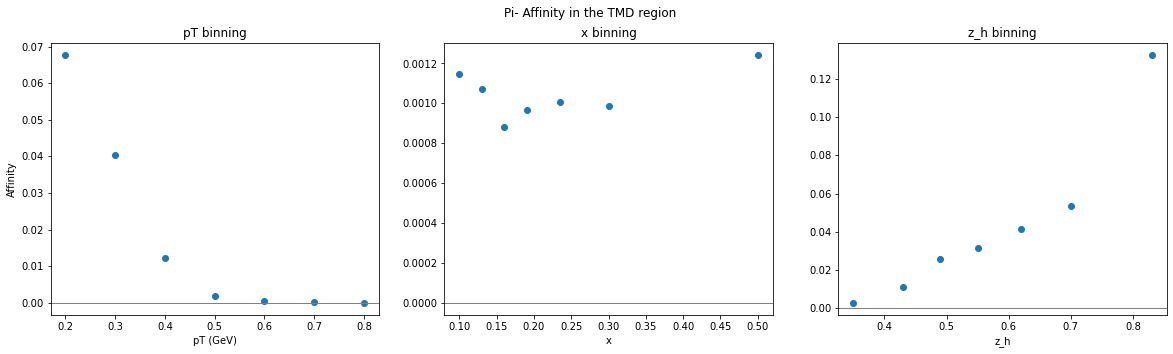

In [23]:
fig2, (ax12, ax22, ax32) = plot.subplots(1, 3, figsize = (20, 5))
fig2.suptitle("Pi- Affinity in the TMD region")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, TMDpTaffinityminus)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, TMDxaffinityminus)
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, TMDzaffinityminus)
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")


[Text(0.5, 0, 'z_h')]

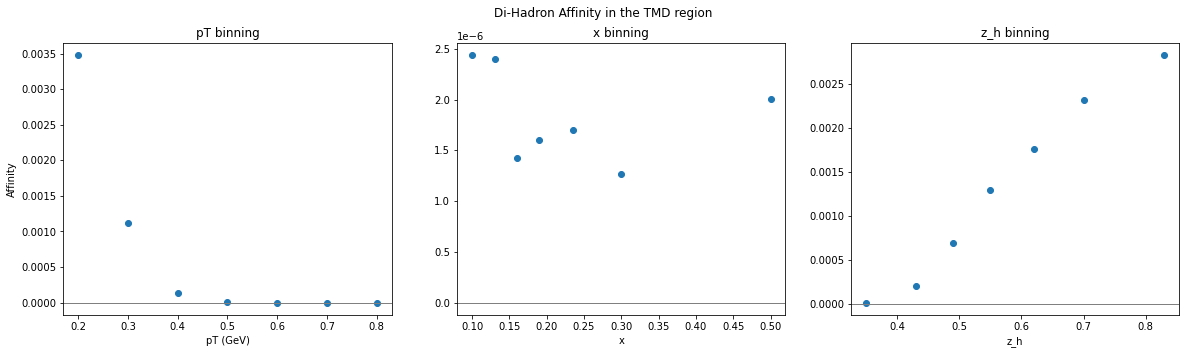

In [24]:
fig2, (ax12, ax22, ax32) = plot.subplots(1, 3, figsize = (20, 5))
fig2.suptitle("Di-Hadron Affinity in the TMD region")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, TMDpTaffinityplus * TMDpTaffinityminus)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, TMDxaffinityplus * TMDxaffinityminus)
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, TMDzaffinityplus * TMDzaffinityminus)
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")


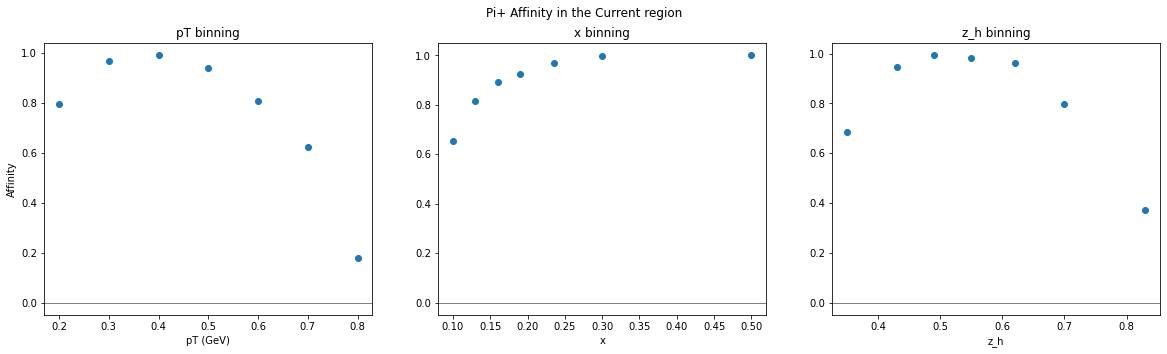

In [25]:
fig3, (ax13, ax23, ax33) = plot.subplots(1, 3, figsize = (20, 5))
fig3.suptitle("Pi+ Affinity in the Current region")
ax13.set(ylabel = "Affinity")
ax13.scatter(pTbinsno0, CurrentpTaffinityplus)
ax13.axhline(y=0, color="gray", lw = 1)
ax13.set_title("pT binning")
ax13.set(xlabel = "pT (GeV)")
ax23.scatter(xbinsno0, Currentxaffinityplus)
ax23.axhline(y=0, color="gray", lw = 1)
ax23.set_title("x binning")
ax23.set(xlabel = "x")
ax33.scatter(zbinsno0, Currentzaffinityplus)
ax33.axhline(y=0, color="gray", lw = 1)
ax33.set_title("z_h binning")
ax33.set(xlabel = "z_h")
plot.savefig("current.png")

[Text(0.5, 0, 'z_h')]

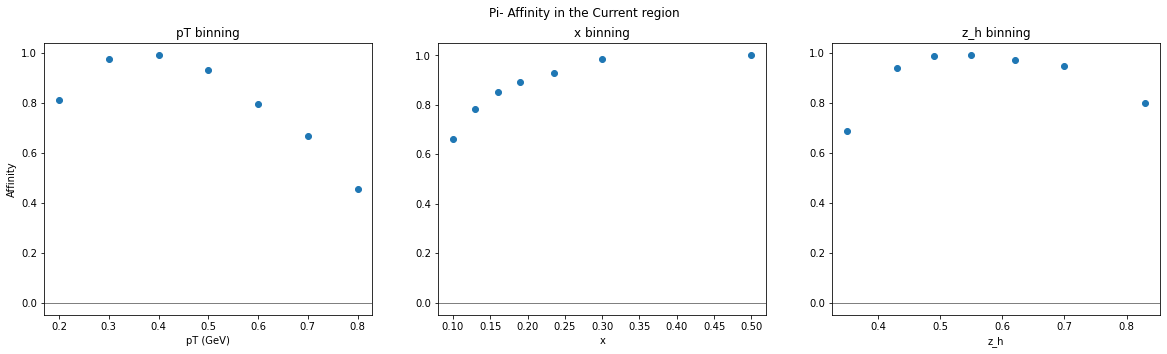

In [26]:
fig3, (ax13, ax23, ax33) = plot.subplots(1, 3, figsize = (20, 5))
fig3.suptitle("Pi- Affinity in the Current region")
ax13.set(ylabel = "Affinity")
ax13.scatter(pTbinsno0, CurrentpTaffinityminus)
ax13.axhline(y=0, color="gray", lw = 1)
ax13.set_title("pT binning")
ax13.set(xlabel = "pT (GeV)")
ax23.scatter(xbinsno0, Currentxaffinityminus)
ax23.axhline(y=0, color="gray", lw = 1)
ax23.set_title("x binning")
ax23.set(xlabel = "x")
ax33.scatter(zbinsno0, Currentzaffinityminus)
ax33.axhline(y=0, color="gray", lw = 1)
ax33.set_title("z_h binning")
ax33.set(xlabel = "z_h")


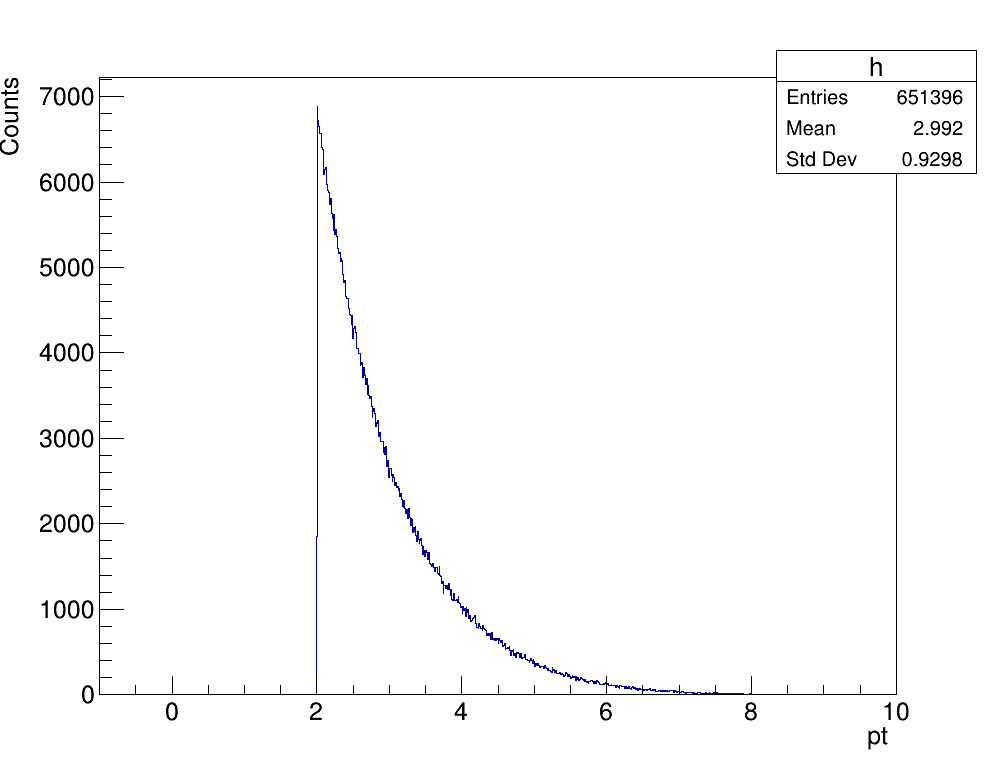

In [297]:
h = d_plus.Filter("Q2 > 2").Histo1D(("h",";pt ;Counts",1000,-1,10),"Q2")
c = TCanvas("c","c",1000,800)
h.Draw()
c.Draw()